[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U9TYyaSjs1hsp3p-C7Y2zNUhHHHzgd4p)

In [89]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [92]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

from Attacks.LBFGS import LBFGSAttack
from Attacks.FGSM import FGSMAttack
from Attacks.VanillaGradient import VanillaGradientAttack

from attack import test_fgsm_mnist , test_LBFGS_mnist,test_vanilla_mnist 
from Net import Net
from utils import *


%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data and Model

First we need to download the model weights and mnist test dataset

In [2]:
mnist_testset = datasets.MNIST('./data_mnist', 
                   train=False,
                   download=False, 
                   transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1,shuffle=True)

In [4]:
#Load pretrained weights
pretrained_model = "weights/lenet_mnist_model.pth"
use_cuda=True 

In [5]:
# Init device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Init the network
model = Net().to(device)

# Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

--- 
# Vanilla SGD attack

Before impleting attacks describes in the paper. We wanted to generete an 'out-of-the-blue' adversarial examples. Where we change a random generated original image to be classified as a certain label by backpropagation. Given an already trained neural network, we progressively backpropagate the loss to the input whilst keeping the weights unchanged. 

We call this attack the Vanilla Attack where the output image is clearly 

In [66]:
vanilla_attack = VanillaGradientAttack(model,device)
img_target, target = next(iter(test_loader))
adv = vanilla_attack(img_target)
proba_adv = vanilla_attack.proba_adv

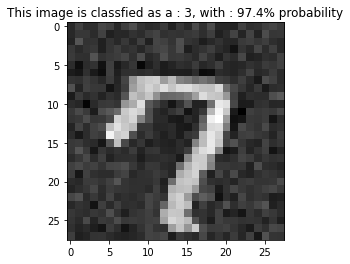

In [68]:
img_adv = adv.squeeze().detach().cpu().numpy()
title = 'This image is classfied as a : {}, with : {}% probability'.format(label.item(),round(proba_adv,1))
plt.imshow(img_adv,cmap='gray')
plt.title(title)
plt.show()

### Testing Targeted Vanilla

We made a change to the Vanilla attack to include in the loss a mesure of distance between the random adversarial exemple and an original image from the dataset.

In [81]:
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=32,shuffle=True)

In [ ]:
accuracies_vanilla = []
examples_vanilla = []
proba_vanilla = []
lmds =[0.01,0.1, 0.5,1]

# Run test for each lambda
for lmd in lmds:
    acc, ex, proba_adv = test_vanilla_mnist(model, device, test_loader, lmd)
    accuracies_vanilla.append(acc)
    examples_vanilla.append(ex)
    proba_vanilla.append(proba_adv)

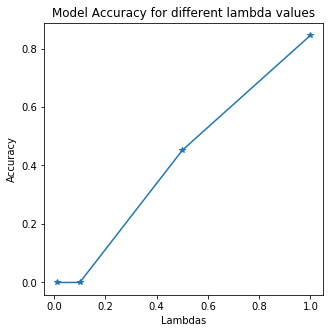

In [83]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(lmds, accuracies_LBFGS, "*-")
plt.title("Model Accuracy for different lambda values")
plt.xlabel("Lambdas")
plt.ylabel("Accuracy")
plt.savefig('Results/Testing Vanilla mnist.png')
plt.show()

### Visualizing examples

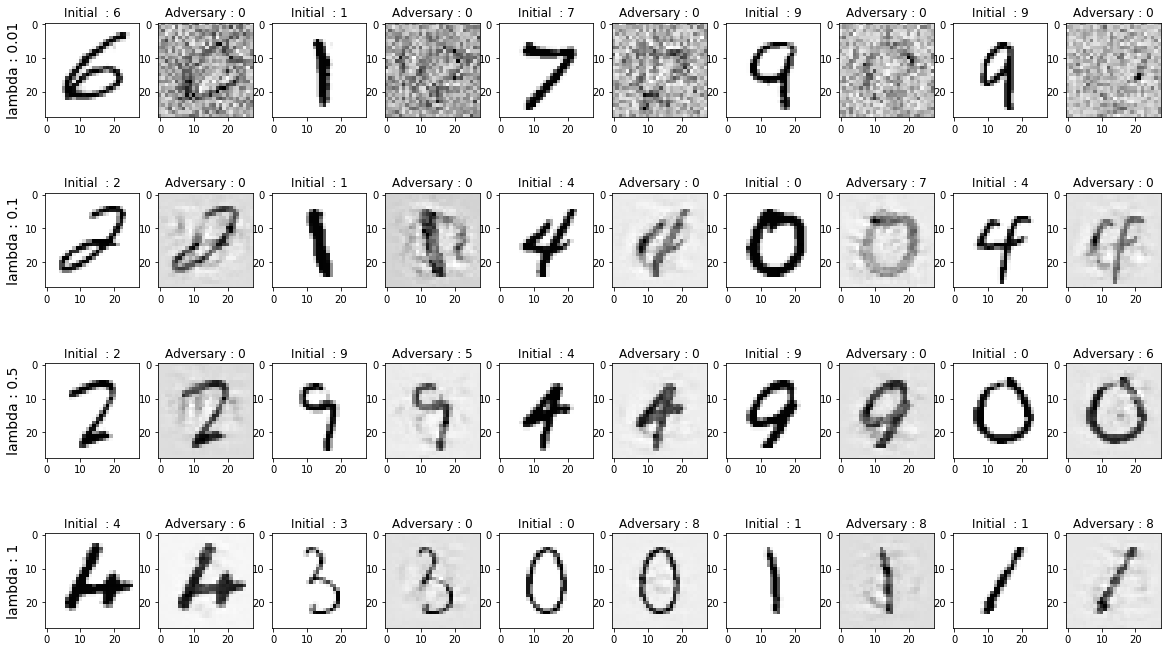

In [80]:
fig , axs = plt.subplots(nrows=len(lmds), ncols=len(examples_vanilla[0])*2,figsize=(20,12))

for i , lmd in enumerate(lmds):
    for j in range(0,len(examples_vanilla[0])):
        original, adversary, init_pred , final_pred = examples_vanilla[i][j]
        axs[i, 2*j].imshow(original,cmap='G
                           
                           reys')
        axs[i,0].set_ylabel("lambda : {}".format(lmd), fontsize=14)
        axs[i, 2*j].set_title('Initial  : {}'.format(init_pred.item()))
        axs[i, 2*j+1].imshow(adversary,cmap='Greys')
        axs[i, 2*j+1].set_title('Adversary : {}'.format(final_pred.item()))
        
plt.savefig('Results/Exemples vanilla mnist.png')

--- 
# FGSM attack 

## Method : 
FGSM came from the idea that adversarial examples can be found using only a linear approximation of the target model,Ian GoodFellow  introduced the fast gradient sign method (FGSM).
FGSM works by linearizing loss function in L∞ neighbourhood, it is designed to go all the way to the edge of a small norm ball surrounding the starting point for the stepFGSM step is designed to go all the way to the edge of a small norm ball surrounding the starting point for the step.

Effectively we compute the gradient regarding the original image using backpropagation then we compute : 

$ pimage= x +  \epsilon * sign(\nabla_{x} J(\theta,x,y))$

where $\epsilon$ : how much we perturbe image $x$

In [ ]:
data, target = next(iter(test_loader)) 
# Getting adversarial exemple generated by FGSM
fgsm = FGSMAttack(model,device,epsilon=0.2, random=True, alpha=0.35)
adv = fgsm(data,target)
# Plotting adversarial example  
imshow_adv(model,data,target,adv)

In [ ]:
accuracies_FGSM = []
examples_FGSM = []
proba_FGSM = []

epsilons =[0.1,0.3,0.5,0.7]
model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, ex, proba_adv = test_fgsm_mnist(model, device, test_loader, eps)
    accuracies_FGSM.append(acc)
    examples_FGSM.append(ex)
    proba_FGSM.append(proba_adv)

### Results 

Plotting the model accuracy and the probability and the mean probability when infering adversarial exemples generated by the FGSM attack.


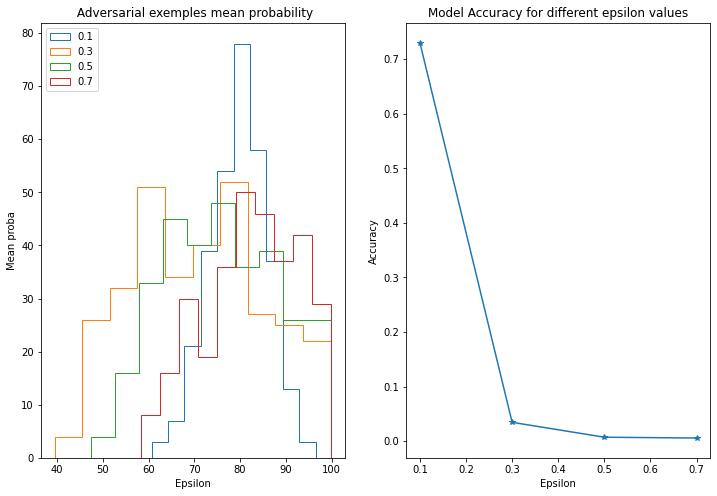

In [611]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
for i, _ in enumerate(epsilons):
    ax[0].hist(proba_FGSM[i],histtype='step', stacked=True, fill=False,label=_)
ax[0].legend()
#ax[0].plot(epsilons, proba_FGSM, "*-")
ax[0].set_title(" Adversarial exemples mean probability")
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("Mean proba")


ax[1].plot(epsilons, accuracies_FGSM, "*-")
ax[1].set_title("Model Accuracy for different epsilon values")
ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("Accuracy")

plt.savefig('Results/Testing FGSM mnist.png')
plt.show()

### Visualizing exemples generated by FGSM attack

We clearly see that the perturbation added to the original data scales with the value of epsilon.

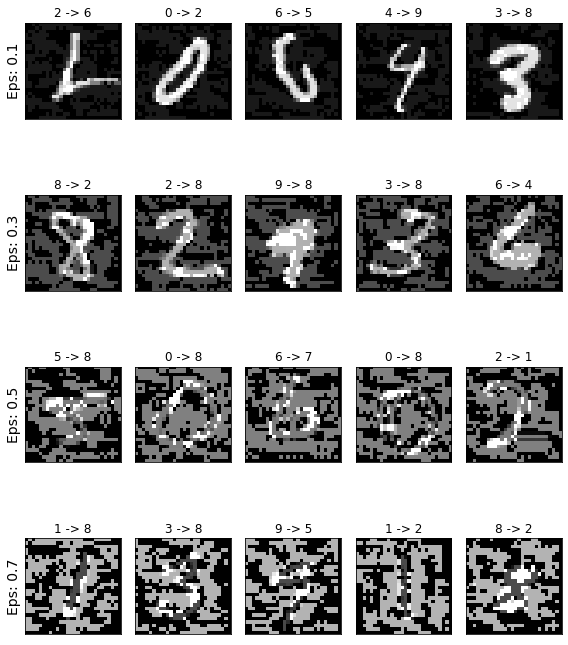

In [466]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_FGSM[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_FGSM[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_FGSM[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()

#plt.savefig('Results/Exemples FGSM mnist.png')
plt.show()


**Advantages of FGSM :**
* Fast to compute
* We use Backpropagation to compute gradient

**Disadvantages:** 
* Setting a very high epsilon procudes exemples that are too different from the original output
* Base FGSM attack doesn't support specifying target for the adversary

--- 

# LBFGS attack

The idea of this method is to solve the following optimization problem:

$min_{x_{adv}}d(x_{adv} , x) \; s.c.\; f(x_{adv}) = y_{target}$

The method is designed to ﬁnd **the smallest possible attack perturbation*** using a quasi Newton optimization method : LBFGS.

In general, the exact computation of D(x, l) is a hard problem, so we approximate it by using a box-constrained L-BFGS.

$ min_{x_{adv}} c*d(x_{adv} , x) + loss(x_{adv},y_{target}) s.c.\; x_{adv} \in [0,1]^n $

Concretly we perform a line search to ﬁnd the minimum c > 0 for the classifier correctly 

In [36]:
from LBFGS import LBFGSAttack

In [9]:
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1,shuffle=True)

data , target = next(iter(test_loader))

lbfgs = LBFGSAttack(model,device)

lbfgs._apply(data,torch.tensor(1),epsilon=0.01)

fig, ax = plt.subplots(1,2,figsize=(8,10))
adv = lbfgs._adv
adv_numpy = adv.squeeze().detach().cpu().numpy()
label_adv = model(adv).max(1, keepdim=True)[1]

#proba_original = torch.exp(model(data)).max().item()*100
proba_adv = F.softmax(lbfgs._output,dim=1).max().item()*100

ax[1].imshow(adv_numpy,cmap='Greys')
ax[1].set_title("Adversarial Exemple : {}, proba ={}%".format(label_adv.item(),
                                                             round(proba_adv,2)))

data_numpy = data.squeeze().detach().cpu().numpy()
ax[0].imshow(data_numpy,cmap='Greys')
#ax[0].set_title("Original image : {}, proba ={}%".format(target.item(),round(proba_original,2)))

### Results

In [ ]:
#final_acc_lbfgs, adv_examples_lbfgs, proba_orig_lbfgs, proba_adv_lbfgs = test_LBFGS_mnist(model,
#                                                                                          device,
#                                                                                          test_loader,
#                                                                                          nb_exemples=1000)

In [ ]:
# This attacks takes a very long time to generate adversaries, we pickled the results
import pickle
with open('weights/lbfgs.pkl','wb') as f :
    pickle.dump((final_acc_lbfgs, adv_examples_lbfgs, proba_orig_lbfgs, proba_adv_lbfgs),f)


 Accuracy for 1000 exemples :  0.126


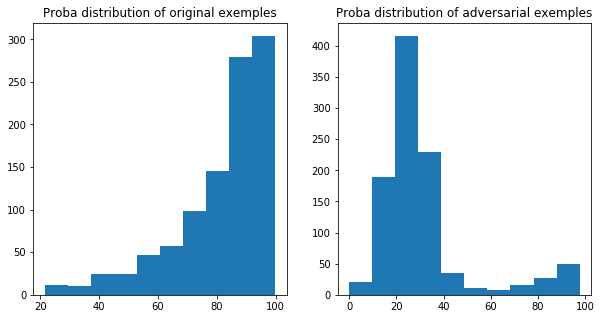

In [65]:
print(" Accuracy for 1000 exemples : ",final_acc_lbfgs)

fig , axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hist(proba_orig_lbfgs)
axs[0].set_title('Proba distribution of original exemples')

axs[1].hist(proba_adv_lbfgs)
axs[1].set_title('Proba distribution of adversarial exemples')

plt.show()

### Visualizing examples

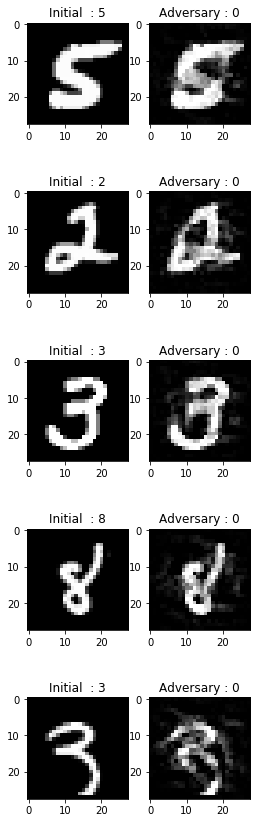

In [53]:
fig , axs = plt.subplots(ncols=2, nrows=len(adv_examples_lbfgs),figsize=(4,15))

for j in range(0,len(adv_examples_lbfgs)):
    original, adversary, init_pred , final_pred = adv_examples_lbfgs[j]
    axs[j,0].imshow(original,cmap='gray')
    axs[j,0].set_title('Initial  : {}'.format(init_pred.item()))
    axs[j,1].imshow(adversary,cmap='gray')
    axs[j,1].set_title('Adversary : {}'.format(final_pred.item()))
        
#plt.savefig('Results/Exemples LBFGS mnist.png')

### LBFGS Attack : Result

The LBFGS attack has a high success rate in generating minimal distortion adversarial example. However, LBFGS attack is very computationnaly expensive . This attack also is not robust to counteract defenses such as reducing the number of bits used to store each pixel

----